In [9]:
import heeps
from heeps.util.paralang import paralang
from heeps.util.save2fits import save2fits
import multiprocessing as mpro
import vip_hci
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
%matplotlib inline

### Initialize parameters

In [10]:
pc = 1.34                   # star distance in parsec
seps = [0.55, 1.1]          # angular separations in AU
cps = [6e-7, 1.5e-7]        # planet contrasts
nhours = 5                  # number of rotation hours
conf = dict(
    mode = 'CVC',
    band = 'N2',
    nframes = 12000,        # number of frames to crop the input data
    duration = 3600*nhours, # duration of the ADI sequence in s
    dit = 0.3*nhours,       # detector integration time in s
    dec = -61,              # deg
    mag = -1.6,             # star mag
)
conf = heeps.config.read_config(**conf)
conf = heeps.config.update_config(verbose=True, **conf)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.42 lam/D)



### Parallactic angle

start = 307.79°, end = 52.21°
rotation = 104.42°


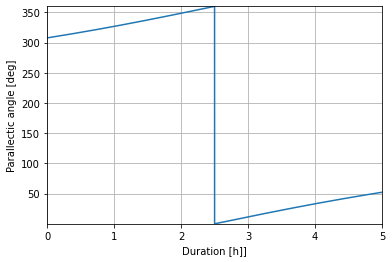

In [11]:
pa = paralang(conf['nframes'], conf['dec'], conf['lat'], conf['duration'])
pa = (pa + 360)%360 
pa_rad = np.deg2rad(pa)
plt.plot(np.arange(len(pa))/len(pa)*nhours, pa)
plt.xlim(0, nhours)
plt.ylim(min(pa), max(pa))
plt.xlabel('Duration [h]]')
plt.ylabel('Parallectic angle [deg]')
plt.grid(True)
print('start = %.2f°, end = %.2f°'%(pa[0], pa[-1]))
print('rotation = %.2f°'%((pa[-1] - pa[0])%360))

### Planet trajectory

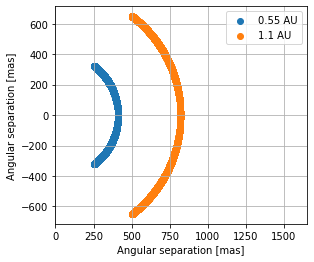

In [12]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/wavefront/point')))
for sep_AU in seps:
    sep = sep_AU/pc*1e3 # mas
    xy = np.array([sep*np.cos(pa_rad), sep*np.sin(pa_rad)]).T
    fits.writeto('point_planet_%sAU_%ss_%sms_%s.fits'%(sep_AU, conf['duration'], 
            int(conf['dit']*1e3), conf['band']), np.float32(-xy), overwrite=True)
    plt.scatter(xy[:,0], xy[:,1], label='%s AU'%sep_AU)
plt.legend()
plt.axis('square')
plt.xlim(left=0)
plt.xlabel('Angular separation [mas]')
plt.ylabel('Angular separation [mas]')
plt.grid(True);

In [13]:
# Note: we save -xy as tip-tilt inputs for HEEPS, so that after FT the negative
# x-axis positions will appear positive. However, the y-axis positions are 
# also flipped, which is equivalent to changing the sign of the parallactic angles.
pa = -pa

# Post-processing

In [14]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/science_case')))

def post_process(conf, method, ncomp=10):
    for case in ['scao_only_5h', 'all_effects_noPSI_noTal_5h']:
        tag = '%s_%s'%(method, ncomp) if 'pca' in method else method
        filename = 'psf_%s_%s_%s_%s.fits'%(tag, conf['band'], conf['mode'], case)
        try:
            frame = fits.getdata(filename)
            print('File loaded: ' + filename)
        except FileNotFoundError:
            print('Creating ' + filename)
            # load off-axis and on-axis PSFs
            psf_OFF = fits.getdata('%s/offaxis_PSF_N2_CVC.fits'%case)
            psf_ON = fits.getdata('%s/onaxis_PSF_N2_CVC.fits'%case)
            # add planets
            for cp, sep in zip(cps, seps):
                psf_ON += cp*fits.getdata('%s_point_planet_%sAU/onaxis_PSF_N2_CVC.fits'%(case, sep))
            # add background
            psf_ON, _ = heeps.contrast.background(psf_ON, psf_OFF, verbose=True, **conf)
            # run VIP
            if 'adi' in method:
                algo = vip_hci.medsub.median_sub
                frame = algo(psf_ON, pa, nproc=mpro.cpu_count(), full_output=False, verbose=True)
            elif 'pca' in method:
                algo = vip_hci.pca.pca
                frame = algo(psf_ON, pa, ncomp=ncomp, nproc=mpro.cpu_count(), full_output=False, verbose=True)
            fits.writeto(filename, frame, overwrite=True)
        plt.figure()
        plt.imshow(frame, origin='lower');

### median-sub ADI

scao_only_5h
File loaded: psf_adi_N2_CVC_scao_only_5h.fits
all_effects_noPSI_noTal_5h
File loaded: psf_adi_N2_CVC_all_effects_noPSI_noTal_5h.fits


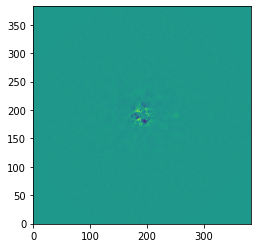

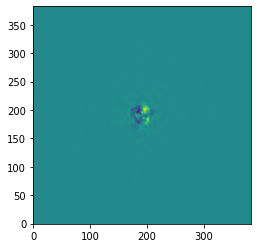

In [15]:
post_process(conf, 'adi')

### PCA, 10 comp

scao_only_5h
File loaded: psf_pca_10_N2_CVC_scao_only_5h.fits
all_effects_noPSI_noTal_5h
File loaded: psf_pca_10_N2_CVC_all_effects_noPSI_noTal_5h.fits


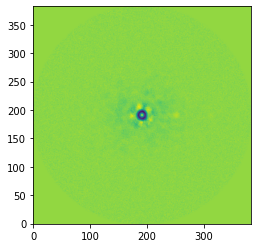

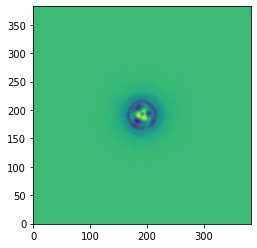

In [16]:
post_process(conf, 'pca_10', ncomp=10)